## Data Preprocessing

In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np

In [2]:
print(tf.__version__)

2.7.0


### Get the dataset

In [3]:
training_dir = '../dataset/training'
validation_dir = '../dataset/validation'
test_dir = '../dataset/test'

BATCH_SIZE = 32
IMG_SIZE = (150, 150)

In [4]:
training_dataset = tf.keras.utils.image_dataset_from_directory(training_dir,
                                                               shuffle=True,
                                                               label_mode='categorical',
                                                               batch_size=BATCH_SIZE,
                                                               image_size=IMG_SIZE)

Found 10320 files belonging to 6 classes.


In [5]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 label_mode='categorical',
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 2580 files belonging to 6 classes.


### Explore the training dataset

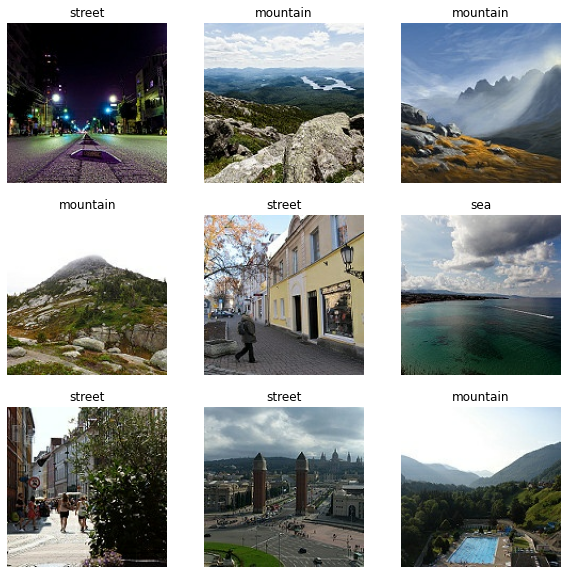

In [6]:
class_names = training_dataset.class_names
plt.figure(figsize=(10, 10))
for images, labels in training_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[np.argmax(labels[i])])
    plt.axis("off")

### Data augmentation

When we don't have a large image dataset, it's a good practice to artificially introduce sample diversity by applying random, yet realistic, transformations to the training images, such as rotation and horizontal flipping. This helps expose the model to different aspects of the training data and reduce overfitting.

In [7]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

Let's repeatedly apply these layers to the same image and see the result.

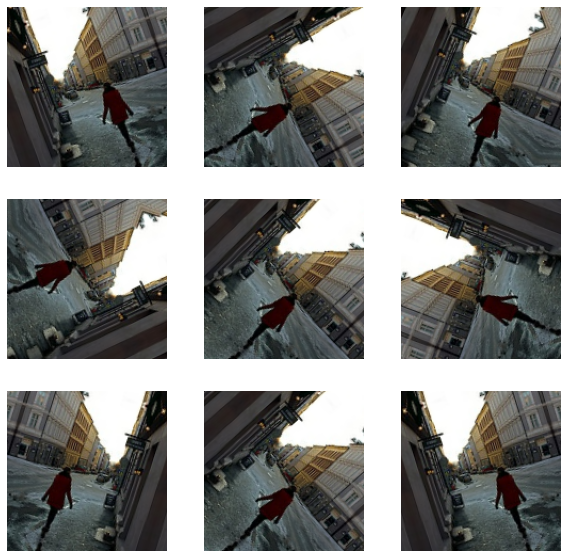

In [8]:
for image, _ in training_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Model Development And Training

### Rescale pixel values

We will use `tf.keras.applications.MobileNetV2` as our base model. This model expects pixel values in `[-1, 1]`, but at this point, the pixel values in your images are in `[0, 255]`. To rescale them, use the preprocessing method included with the model.

In [9]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

### Creation of the base model using a CNN architecture

In [10]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

base_model.trainable = False

9420800/9406464 [==============================] - 1s 0us/step


In [11]:
# Let's take a look at the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 75, 75, 32)   864         ['input_1[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 75, 75, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 75, 75, 32)   0           ['bn_Conv1[0][

                                                                  'block_9_project_BN[0][0]']     
                                                                                                  
 block_10_expand (Conv2D)       (None, 10, 10, 384)  24576       ['block_9_add[0][0]']            
                                                                                                  
 block_10_expand_BN (BatchNorma  (None, 10, 10, 384)  1536       ['block_10_expand[0][0]']        
 lization)                                                                                        
                                                                                                  
 block_10_expand_relu (ReLU)    (None, 10, 10, 384)  0           ['block_10_expand_BN[0][0]']     
                                                                                                  
 block_10_depthwise (DepthwiseC  (None, 10, 10, 384)  3456       ['block_10_expand_relu[0][0]']   
 onv2D)   

### Add a classification head

To generate predictions from the block of features, average over the spatial `5x5` spatial locations, using a `tf.keras.layers.GlobalAveragePooling2D` layer to convert the features to  a single 1280-element vector per image.

In [12]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

Apply a `tf.keras.layers.Dense` layer to convert these features into a single prediction per image.

In [13]:
prediction_layer = tf.keras.layers.Dense(len(class_names), activation='softmax')

Build a model by chaining together the data augmentation, rescaling, `base_model` and feature extractor layers using the [Keras Functional API](https://www.tensorflow.org/guide/keras/functional).

In [14]:
inputs = tf.keras.Input(shape=(150, 150, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

### Compile the model (Feature extraction)

In [15]:
from tensorflow.keras.optimizers import Adam

base_learning_rate = 0.0001

opt = Adam(learning_rate=base_learning_rate)

model.compile(loss='categorical_crossentropy',
              optimizer = opt,
              metrics=['accuracy'])

In [16]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

In [17]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

81/81 [==============================] - 29s 337ms/step - loss: 2.5239 - accuracy: 0.1426
initial loss: 2.52
initial accuracy: 0.14


### Model training

In [18]:
history = model.fit(training_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
323/323 [==============================] - 152s 460ms/step - loss: 1.3598 - accuracy: 0.4899 - val_loss: 0.8146 - val_accuracy: 0.7143
Epoch 2/10
323/323 [==============================] - 152s 471ms/step - loss: 0.7456 - accuracy: 0.7173 - val_loss: 0.5553 - val_accuracy: 0.8027
Epoch 3/10
323/323 [==============================] - 153s 474ms/step - loss: 0.6067 - accuracy: 0.7788 - val_loss: 0.4643 - val_accuracy: 0.8326
Epoch 4/10
323/323 [==============================] - 154s 478ms/step - loss: 0.5392 - accuracy: 0.7994 - val_loss: 0.4149 - val_accuracy: 0.8473
Epoch 5/10
323/323 [==============================] - 154s 477ms/step - loss: 0.4971 - accuracy: 0.8170 - val_loss: 0.3890 - val_accuracy: 0.8612
Epoch 6/10
323/323 [==============================] - 173s 536ms/step - loss: 0.4773 - accuracy: 0.8269 - val_loss: 0.3648 - val_accuracy: 0.8659
Epoch 7/10
323/323 [==============================] - 159s 492ms/step - loss: 0.4665 - accuracy: 0.8286 - val_loss: 0.3541 -

In [19]:
base_model.trainable = True

fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

### Recompile the model (Fine tuning)

In [20]:
model.compile(loss='categorical_crossentropy',
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10),
              metrics=['accuracy'])

In [21]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 150, 150, 3)       0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 150, 150, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 150, 150, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                             

### Continue training and save the model

In [22]:
fine_tuning_epochs = 10

total_epochs =  initial_epochs + fine_tuning_epochs

model.fit(training_dataset,
          epochs=total_epochs,
          initial_epoch=history.epoch[-1],
          validation_data=validation_dataset)

Epoch 10/20
323/323 [==============================] - 226s 683ms/step - loss: 0.4059 - accuracy: 0.8538 - val_loss: 0.2961 - val_accuracy: 0.8907
Epoch 11/20
323/323 [==============================] - 218s 675ms/step - loss: 0.3475 - accuracy: 0.8737 - val_loss: 0.2621 - val_accuracy: 0.8996
Epoch 12/20
323/323 [==============================] - 218s 675ms/step - loss: 0.3216 - accuracy: 0.8833 - val_loss: 0.2465 - val_accuracy: 0.9027
Epoch 13/20
323/323 [==============================] - 223s 690ms/step - loss: 0.2965 - accuracy: 0.8937 - val_loss: 0.2419 - val_accuracy: 0.9093
Epoch 14/20
323/323 [==============================] - 219s 678ms/step - loss: 0.2842 - accuracy: 0.8975 - val_loss: 0.2238 - val_accuracy: 0.9171
Epoch 15/20
323/323 [==============================] - 221s 685ms/step - loss: 0.2669 - accuracy: 0.9021 - val_loss: 0.2228 - val_accuracy: 0.9194
Epoch 16/20
323/323 [==============================] - 227s 702ms/step - loss: 0.2553 - accuracy: 0.9082 - val_loss: 0

### Save the model

In [25]:
model.save('../model/')

KeyError: "Failed to add concrete function 'b'__inference_model_layer_call_fn_111877'' to object-based SavedModel as it captures tensor <tf.Tensor: shape=(), dtype=resource, value=<Resource Tensor>> which is unsupported or not reachable from root. One reason could be that a stateful object or a variable that the function depends on is not assigned to an attribute of the serialized trackable object (see SaveTest.test_captures_unreachable_variable)."